In [1]:
%load_ext autoreload
%autoreload 2   

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [14]:
# Custom GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.xavier_uniform_(self.weight)  # Better initialization

    def forward(self, features, adj):
        support = torch.mm(features, self.weight)
        output = torch.mm(adj, support)
        return output


# Full GCN Model with 3 layers
class GCN(nn.Module):
    def __init__(self, nfeat, nhid1, nhid2, nclass):
        super(GCN, self).__init__()
        self.gc1 = GCNLayer(nfeat, nhid1)
        self.gc2 = GCNLayer(nhid1, nhid2)
        self.gc3 = GCNLayer(nhid2, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.relu(self.gc2(x, adj))
        embeddings = x  # Extract embeddings from the last hidden layer
        x = self.gc3(x, adj)
        return F.log_softmax(x, dim=1), embeddings


In [15]:
# Load Zachary's Karate Club graph
G = nx.karate_club_graph()
n_nodes = G.number_of_nodes()  # 34

# Adjacency matrix (add self-loops)
A = nx.to_numpy_array(G) + np.eye(n_nodes)
A = torch.FloatTensor(A)

# Degree matrix and normalized adjacency
degrees = torch.sum(A, dim=1)
D_inv_sqrt = torch.diag(torch.pow(degrees, -0.5))
adj_norm = torch.mm(torch.mm(D_inv_sqrt, A), D_inv_sqrt)

# Features: Identity matrix (featureless graph)
features = torch.eye(n_nodes)

# Labels: Binary (0 for 'Mr. Hi', 1 for 'Officer')
labels_list = [0 if G.nodes[i]["club"] == "Mr. Hi" else 1 for i in range(n_nodes)]
labels = torch.LongTensor(labels_list)

# Masks (fixed split for simplicity)
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)
train_mask[:20] = 1
val_mask[20:27] = 1
test_mask[27:] = 1


In [17]:
# Model, optimizer, loss
model = GCN(nfeat=n_nodes, nhid1=32, nhid2=16, nclass=2)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    output, _ = model(features, adj_norm)
    loss = F.nll_loss(output[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss {loss.item():.4f}")

# Evaluate on validation (for hyperparam tuning, if needed)
model.eval()
with torch.no_grad():
    output, _ = model(features, adj_norm)
    val_loss = F.nll_loss(output[val_mask], labels[val_mask])
    print(f"Validation Loss: {val_loss.item():.4f}")

# Inference
model.eval()
with torch.no_grad():
    logits, embeddings = model(features, adj_norm)
    pred = logits.argmax(dim=1)
    test_acc = accuracy_score(labels[test_mask].numpy(), pred[test_mask].numpy())
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 0: Train Loss 0.7176
Epoch 50: Train Loss 0.1457
Epoch 100: Train Loss 0.0112
Epoch 150: Train Loss 0.0072
Validation Loss: 0.0013
Test Accuracy: 1.0000


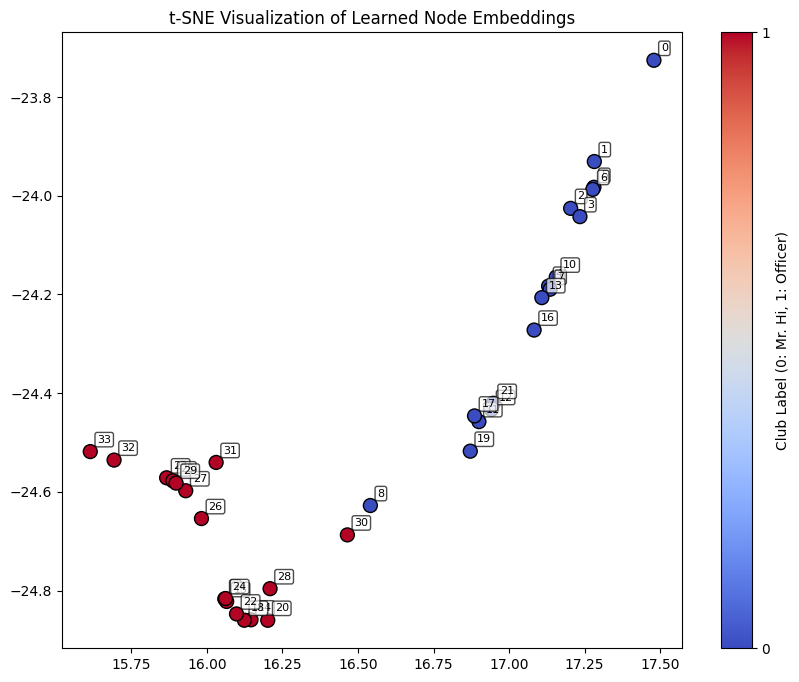

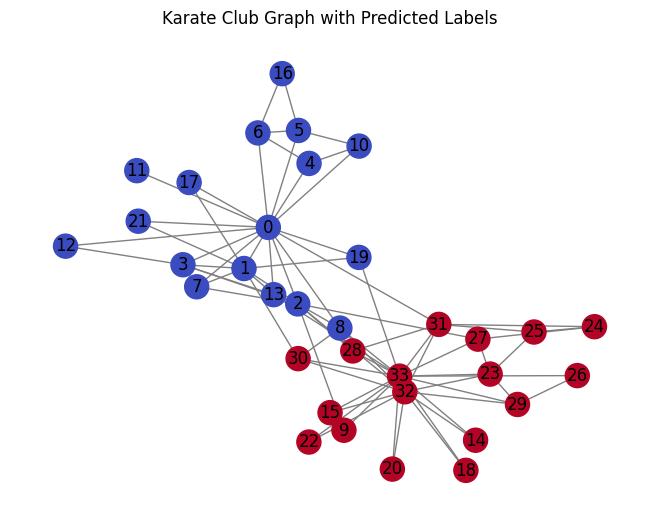

In [18]:
# Embeddings visualization with t-SNE
embeddings_np = embeddings.detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
plt.scatter(
    embed_2d[:, 0],
    embed_2d[:, 1],
    c=labels.numpy(),
    cmap="coolwarm",
    edgecolor="k",
    s=100,
)

# Add node labels to each point
for i in range(len(embed_2d)):
    plt.annotate(
        str(i),
        (embed_2d[i, 0], embed_2d[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
        ha="left",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7),
    )

plt.colorbar(ticks=[0, 1], label="Club Label (0: Mr. Hi, 1: Officer)")
plt.title("t-SNE Visualization of Learned Node Embeddings")
plt.show()

# Graph visualization with predicted labels
pos = nx.spring_layout(G, seed=42)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=pred.numpy(),
    cmap="coolwarm",
    edge_color="gray",
)
plt.title("Karate Club Graph with Predicted Labels")
plt.show()